In [56]:
import pulp
import pandas as pd
import random

In [57]:
# Generates a dataset of residents and randomizes their hospital preferences

random.seed(42)

# Residents: 0001 → 0300
residents = [f"{i:04d}" for i in range(1, 301)]

# Hospitals: 9001 → 9131
hospitals = [f"{i:04d}" for i in range(9001, 9331)]  

def generate_prefs():
    """Return a random list of 10-20 hospital IDs as a comma-separated string."""
    k = random.randint(10, 20)        
    selected = random.sample(hospitals, k)  
    return ",".join(selected)         


prefs_list = [generate_prefs() for _ in residents]

df = pd.DataFrame({
    "Names": residents,
    "Preferences": prefs_list
})

output_path = "residents_prefs.xlsx"
df.to_excel(output_path, index=False)

print(f"Excel file generated successfully: {output_path}")
print(df.head())  


Excel file generated successfully: residents_prefs.xlsx
  Names                                        Preferences
0  0001  9058,9013,9141,9126,9115,9072,9053,9280,9045,9...
1  0002  9280,9215,9113,9230,9302,9143,9004,9082,9217,9...
2  0003  9048,9195,9050,9184,9177,9310,9136,9023,9236,9...
3  0004  9041,9283,9151,9322,9317,9186,9296,9099,9036,9...
4  0005  9326,9187,9084,9190,9182,9108,9137,9037,9312,9...


In [58]:
# Builds a sample dataset for hospitals and their capacities

hospitals = [f"{i:04d}" for i in range(9001, 9331)]  # 9001 → 9130

# Sets capacities of hospitals to indvcapacity
indvcapacity = 1
capacities = [indvcapacity] * len(hospitals)

df = pd.DataFrame({
    "Hospital": hospitals,
    "Capacity": capacities
})

output_path = "hospital_capacities.xlsx"
df.to_excel(output_path, index=False)

print(f"Hospital capacities Excel generated: {output_path}")
print(df.head())  

Hospital capacities Excel generated: hospital_capacities.xlsx
  Hospital  Capacity
0     9001         1
1     9002         1
2     9003         1
3     9004         1
4     9005         1


In [59]:
import pandas as pd

# Load Excel files and read the Excel files into dataframes. 
# We assume the Excel file "residents_prefs.xlsx" has two columns, one with the resident's name labeled "Names",  
# one with list of preferences separated by commas, in order of rank.
# For example:
#    Names     Preferences
# 0   r1        A,B,C,D
# 1   r2        B,D
# 2   r3        A,B,F,G,H
#
# This signifies that Dr. r1's rankings are 1. A, 2. B, 3. C, 4. D. And so on.
# For "hospital_capacities.xlsx", we assume that the first column is labeled "Hospital", and the second one is labeled "Capacity".
# The columns for hospital_capacities.xlsx should be strings for Hospital, int for Capacity.

df = pd.read_excel("residents_prefs.xlsx")
cap_df = pd.read_excel("hospital_capacities.xlsx")    # columns: Hospital, Capacity



# Proceed to read the residents Excel file into a dict(string,list). The list will also be ordered by rank. 
residents = df["Names"].astype(str).tolist()

# Append "None" to list of hospitals, with excess capacity. 
cap_df.loc[len(cap_df)] = ["None", len(residents)+1]

# Normalize formatting
cap_df = cap_df.copy()
cap_df["Hospital"] = cap_df["Hospital"].astype(str).str.strip().str.zfill(4)
cap_df["Capacity"] = cap_df["Capacity"].astype(int).clip(lower=0)

hospitals = dict(zip(cap_df["Hospital"], cap_df["Capacity"]))

preferences = {}
for _, row in df.iterrows():
    name = str(row["Names"]).strip()
    pref_str = str(row["Preferences"]) if pd.notna(row["Preferences"]) else ""
    raw_list = [p.strip() for p in pref_str.split(",") if p.strip()]

    # normalize & filter
    hospital_list = []
    for h in raw_list:
        h_norm = str(h).strip().zfill(4)  
        if h_norm in hospitals:
            hospital_list.append(h_norm)
    
    # Append the created hospital "None" at the end of each resident's preference list
    hospital_list.append("None")

    # to (hospital, rank) tuples: 1,2,3,...
    preferences[name] = [(h, r+1) for r, h in enumerate(hospital_list)]
    
    
    


In [60]:
# edges is a list of all possible triplets (i,j,r) for which i and j are "successful" rank-r pairings. 
# For example, (0001, 9058, 1) would be an element of edges if and only if doctor 0001 selected hospital 9058 as their #1 choice
# These pairs will later be used to determine maximum rank pairs.

edges = []  # list of (resident, hospital, rank)
for i in residents:
    for (j, r) in preferences.get(i, []):
        edges.append((i, j, r))

if not edges:
    raise ValueError("No edges found from preferences after normalization.")

max_rank = max(r for (_, _, r) in edges)


In [61]:
# Create Linear Programming problem in PuLP, Rank_Maximal_AllRanks, and sets the problem to maximize.

prob = pulp.LpProblem("RankMaximal_AllRanks", pulp.LpMaximize)

In [62]:
# Create decision variable x. Xij = 1 if we assign resident i to hospital j, and 0 otherwise.

x = {(i, j): pulp.LpVariable(f"x_{i}_{j}", lowBound=0, upBound=1, cat="Continuous")
     for (i, j, _) in edges}

In [63]:
# Adds constraint that any resident i can only be assigned to maximum of one hospital. I.e. sum of xi over j is 1.

for i in residents:
    prob += (
        pulp.lpSum(x[(ii, j)] for (ii, j) in x.keys() if ii == i) <= 1,
        f"Resident_{i}_at_most_one"
    )

In [64]:
# Adds constraint that any hospital j must have less residents than its capacity.

for j, cap in hospitals.items():
    prob += (
        pulp.lpSum(x[(i, jj)] for (i, jj) in x.keys() if jj == j) <= int(cap),
        f"Hospital_{j}_capacity"
    )

In [65]:
# Helpful variables to assist with maximizing
# all_match_expr is the sum of all decision variables across all hospitals and all residents. It represents the # of assignments that have been made
all_match_expr = pulp.lpSum(x.values())

# Building rank_expr as the vector {r1,r2,r3...} that represents how many assignments are made at each rank. I.e {103, 4, 3,...} would represent 
# 103 first rank matches, 4 second rank matches, 3 third rank matches, etc. 
rank_expr = {}

for r in range(1, max_rank + 1):
    rank_expr[r] = pulp.lpSum(x[(i, j)] for (i, j, rr) in edges if rr == r)

In [66]:
# First we set objective to our previously defined variable all_match_expr to maximize TOTAL assignments
prob.setObjective(all_match_expr)

# Solve the linear program and check that an optimal solution was found.
prob.solve(pulp.PULP_CBC_CMD(msg=False))
if pulp.LpStatus[prob.status] != "Optimal":
    raise RuntimeError("All matching not Optimal.")

# Extract the maximum number of total assignments as K_Total.
K_total = int(round(pulp.value(all_match_expr)))

# "Lock" all_match_expr to K_Total, i.e. there cannot be less assignments than the maximum number of assignments.
# (See explanation in demo script for why we do this) 
prob += (all_match_expr == K_total), "LOCK_total_matches"
locks.append(("total", K_total))

# Set up for loop for all ranks
for r in range(1, max_rank + 1):
    
    # Set the objective as maximizing assignments for the current rank.
    prob.setObjective(rank_expr[r])
    
    # Solve and check for optimal solution.
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    if pulp.LpStatus[prob.status] != "Optimal":
        raise RuntimeError(f"{r} assignments not Optimal.")
        
    # Extract the maximum number of assignments for current rank w/ given constraints.
    Kr = int(round(pulp.value(rank_expr[r])))

    # Stores number of residents matched at that rank as signature[r]
    signature[r] = Kr

    # "Lock" rank_expr[r] == Kr by adding this as a constraint. 
    prob += (rank_expr[r] == Kr), f"LOCK_rank_{r}"
    locks.append((r, Kr))

In [67]:
# Once exact maximum numbers for each rank are found, extract one feasible solution.

prob.setObjective(pulp.lpSum(0 * v for v in x.values()))
prob.solve(pulp.PULP_CBC_CMD(msg=False))
print("Final Status:", pulp.LpStatus[prob.status])


Final Status: Optimal


In [68]:
# Build the matching list from the optimal solution
matching = []
for (i, j), var in x.items():
    val = var.value()
    if val is not None and val >= 1 - TOL:
        matching.append((i, j))

# Print Results 
print(f"# residents: {len(residents)}")
print(f"# hospitals: {len(hospitals)}")
print(f"Locked total matches: {K_total}")
print("Rank-maximal signature (count per rank):")
for r in range(1, max_rank + 1):
    print(f"  rank {r}: {signature.get(r, 0)}")
print(f"# matched pairs in solution: {len(matching)}")

# Example: preview first 15 assignments
print("Sample matches:", matching[:15])


# residents: 300
# hospitals: 331
Locked total matches: 300
Rank-maximal signature (count per rank):
  rank 1: 195
  rank 2: 56
  rank 3: 17
  rank 4: 11
  rank 5: 7
  rank 6: 5
  rank 7: 1
  rank 8: 3
  rank 9: 1
  rank 10: 1
  rank 11: 1
  rank 12: 0
  rank 13: 0
  rank 14: 1
  rank 15: 0
  rank 16: 1
  rank 17: 0
  rank 18: 0
  rank 19: 0
  rank 20: 0
  rank 21: 0
# matched pairs in solution: 300
Sample matches: [('1', '9058'), ('2', '9280'), ('3', '9048'), ('4', '9283'), ('5', '9326'), ('6', '9167'), ('7', '9276'), ('8', '9057'), ('9', '9129'), ('10', '9321'), ('11', '9307'), ('12', '9041'), ('13', '9192'), ('14', '9122'), ('15', '9221')]


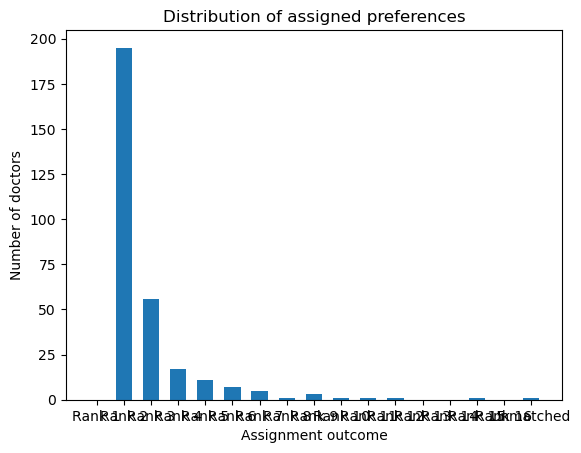

{'first_choice_matches': 195, 'unmatched_doctors': 0, 'weighted_score': 234.6038059163059, 'average_rank': 1.86}


In [69]:
def load_data(pref_file, assign_file):
    preferences = pd.read_csv(pref_file, header=None).to_numpy()
    assignments = pd.read_csv(assign_file, header=None).to_numpy().flatten()
    return preferences, assignments

def evaluate_matching(preferences, assignments, plot_histogram=True):

    num_doctors, num_hospitals = preferences.shape

    # The first-choice hospital for each doctor (hospital ID with the smallest preference value)
    first_choices = np.argmin(preferences, axis=1)

    # Number of doctors matched to their first-choice hospital
    matched_first_choice = np.sum(assignments == first_choices)

    # Number of doctors who were not matched
    unmatched_count = np.sum(assignments == -1)

    # Weighted score: 1 for first choice, 1/2 for second choice, 1/3 for third, etc.
    weighted_score = 0
    ranks = []  # store each doctor's assigned rank
    for i, hospital in enumerate(assignments):
        if hospital == -1:
            continue
        # Find the rank of the assigned hospital for this doctor
        rank = np.argsort(preferences[i]).tolist().index(hospital) + 1
        ranks.append(rank)
        weighted_score += 1 / rank

    # Average rank
    avg_rank = float(np.mean(ranks)) if ranks else None

    # Plot histogram of ranks if requested
    if plot_histogram and ranks:
        values = ranks + [0] * unmatched_count  # 0 unmatched
        labels = [f"Rank {i}" for i in range(1, max(ranks) + 1)] + ["Unmatched"] if ranks else ["Unmatched"]

        counts = [values.count(0)] + [values.count(i) for i in range(1, max(ranks) + 1)] if ranks else [unmatched_count]

        plt.bar(range(len(counts)), counts, tick_label=labels, width=0.6)
        plt.xlabel("Assignment outcome")
        plt.ylabel("Number of doctors")
        plt.title("Distribution of assigned preferences")
        plt.show()


    return {
        "first_choice_matches": int(matched_first_choice),
        "unmatched_doctors": int(unmatched_count),
        "weighted_score": float(weighted_score),
        "average_rank": avg_rank
    }

import numpy as np  

# Map hospitals and residents to indices for matrix form 
resident_to_idx = {res: idx for idx, res in enumerate(residents)}   
hospital_list = sorted(hospitals.keys())                           
hospital_to_idx = {h: idx for idx, h in enumerate(hospital_list)}   

# Build preference matrix: rows=residents, cols=hospitals, values=ranks 
pref_matrix = np.full((len(residents), len(hospital_list)), fill_value=9999)  
for i, prefs in preferences.items():                                         
    for h, r in prefs:                                                        
        pref_matrix[resident_to_idx[i], hospital_to_idx[h]] = r               

# Build assignment vector: hospital index or -1 if unmatched 
assign_vector = np.full(len(residents), -1)                                   
for i, j in matching:                                                         
    ri = resident_to_idx[i]                                                  
    hj = hospital_to_idx[j]                                                   
    assign_vector[ri] = hj                                                    

# Save to CSV for evaluation function 
np.savetxt("preferences.csv", pref_matrix, delimiter=",", fmt="%d")           
np.savetxt("assignments.csv", assign_vector, delimiter=",", fmt="%d")         


from matplotlib import pyplot as plt   

# Use the evaluation code
preferences_arr, assignments_arr = load_data("preferences.csv", "assignments.csv")   
results = evaluate_matching(preferences_arr, assignments_arr, plot_histogram=True)   
print(results)                                                                       